## Spark Funds Data Analysis
Spark Funds wants to make investments in a few companies. The CEO of Spark Funds wants to understand the global trends in investments so that she can take the investment decisions effectively.
### Constraints for investments
- 5 to 15 million USD
- English-speaking countries
- Invest where most other investors are investing. This pattern is often observed among early stage startup investors
### The objective is to identify the best(where most investors are investing):
- sectors : eight 'main sectors'
- countries : most heavily invested
- a suitable investment type for making investments : investment amounts in the venture, seed, angel, private equity etc
### Investment amount increasing order
Seed/angel (Startup) ==> venture ==> Private equity

*Spark Funds wants to choose one of these four investment types for each potential investment they will make.*

###  Imports

In [1]:
import csv
import functools
import operator
import string
from typing import Collection, Iterable, List, Sequence, Tuple
import enchant
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from colorama import Back, Fore, Style
from fuzzywuzzy import fuzz
from IPython.display import display
from matplotlib.pyplot import title
from nltk.corpus import words
from numpy.lib.arraysetops import isin, unique
from tqdm import tqdm

sns.set(style="whitegrid")
%matplotlib inline



### Constant Variable

In [2]:

default_ecoding = 'iso-8859-1'
dollar_formatting = '${0:,.2f}'
float_formatting = '{0:,.2f}'
int_formatting = '{0:,.0f}'

# Ref: https://www.kaggle.com/maunish/osic-super-cool-eda-and-pytorch-baseline/notebook
# used for changing color of text in print statement
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL


# column names
name_c = 'name'
name_c_clean = 'name_clean'
permalink = 'permalink'
permalink_clean = 'permalink_clean'
homepage_url = 'homepage_url'
category_list = 'category_list'
category_list_clean = 'category_list_clean'
status_c = 'status'
country_code_c = 'country_code'
country_code_c_clean = 'country_code_clean'
primary_sector = 'primary_sector'
main_sector = 'main_sector'


company_permalink = 'company_permalink'
company_permalink_clean = 'company_permalink_clean'
funding_round_type = 'funding_round_type'
raised_amount_usd = 'raised_amount_usd'

In [3]:
def read_nonutf8_encoded_file(file_name, encoding='iso-8859-1'):
    return pd.read_csv(file_name, encoding=encoding)

In [4]:
companies_raw = read_nonutf8_encoded_file("companies.csv")

In [5]:
companies_raw.shape

(66368, 10)

In [6]:
companies_raw.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [7]:
companies_raw.iloc[422]

permalink                             /Organization/51Intern-Com-2
name                            51intern.com Ã¨â¹Â±Ã¨â¦Â¾Ã§Â½â
homepage_url                               http://www.51intern.com
category_list    Career Management|Human Resources|Search|SNS|S...
status                                                   operating
country_code                                                   CHN
state_code                                                      23
region                                                    Shanghai
city                                                      Shanghai
founded_at                                              18-05-2010
Name: 422, dtype: object

**We need to remove special chars**

In [8]:
companies_raw.isnull().any()

permalink        False
name              True
homepage_url      True
category_list     True
status           False
country_code      True
state_code        True
region            True
city              True
founded_at        True
dtype: bool

In [9]:
companies_raw.isnull().sum().sum()


54991

**Column wise nulls**

In [10]:
companies_raw.isnull().sum()

permalink            0
name                 1
homepage_url      5058
category_list     3148
status               0
country_code      6958
state_code        8547
region            8030
city              8028
founded_at       15221
dtype: int64

**Nulls percentage**

In [11]:
((companies_raw.isnull().sum()*100)/companies_raw.shape[0])

permalink         0.000000
name              0.001507
homepage_url      7.621143
category_list     4.743250
status            0.000000
country_code     10.483968
state_code       12.878194
region           12.099204
city             12.096191
founded_at       22.934245
dtype: float64

 - founded_at is column with highest missing percentage which is ~23%
 - state_code,region and city are in ~12-13%
 - country_code,homepage_url, category_list and name as well have missing values
 - We will remove founded at, state code, region and country columns
 - We will remove the rows with missing values in name, category list and home URL columns because they have around 10% missing values


In [12]:
companies_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   permalink      66368 non-null  object
 1   name           66367 non-null  object
 2   homepage_url   61310 non-null  object
 3   category_list  63220 non-null  object
 4   status         66368 non-null  object
 5   country_code   59410 non-null  object
 6   state_code     57821 non-null  object
 7   region         58338 non-null  object
 8   city           58340 non-null  object
 9   founded_at     51147 non-null  object
dtypes: object(10)
memory usage: 5.1+ MB


In [13]:
companies_raw[name_c].value_counts()

#NAME?               4
Karma                4
Roost                4
Spire                4
Blink                4
                    ..
The Richman Group    1
24 Quan              1
Peeky                1
ShortPoint           1
Bioheart             1
Name: name, Length: 66099, dtype: int64

In [14]:
companies_raw[permalink].value_counts()

/Organization/Mortgagebite-Com              1
/Organization/Alignent-Software             1
/Organization/Sniffsnout-Com                1
/Organization/Silicon-Storage-Technology    1
/Organization/Plurogen-Therapeutics         1
                                           ..
/Organization/Omnino-Llp                    1
/Organization/Farm-At-Hand                  1
/Organization/Walkbase                      1
/Organization/Groupay                       1
/Organization/Snowflake-Youth-Foundation    1
Name: permalink, Length: 66368, dtype: int64

In [15]:
companies_raw[permalink].apply(lambda x: str(x).split("/")[1]).unique()

array(['Organization'], dtype=object)

**As we can see that we have only one prefix "Organization" we can remove it if required**

In [16]:
companies_raw[status_c].unique()


array(['operating', 'acquired', 'closed', 'ipo'], dtype=object)

**We need to remove closed and acquired companies as we can not invest into them**

In [17]:
rounds2_raw = read_nonutf8_encoded_file("rounds2.csv")


In [18]:
rounds2_raw.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


**We'll keep only company_permalink, funding_round_type, raised_amount_usd and drop funding_round_permalink, funding_round_code, funded_at as these are not required in our analysis**

In [19]:
rounds2_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   company_permalink        114949 non-null  object 
 1   funding_round_permalink  114949 non-null  object 
 2   funding_round_type       114949 non-null  object 
 3   funding_round_code       31140 non-null   object 
 4   funded_at                114949 non-null  object 
 5   raised_amount_usd        94959 non-null   float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [20]:
rounds2_raw.shape

(114949, 6)

In [21]:
rounds2_raw.isnull().sum().sum()

103799

Column wise nulls

In [22]:
rounds2_raw.isnull().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
dtype: int64

Nulls percentage

In [23]:
((rounds2_raw.isnull().sum()*100)/rounds2_raw.shape[0])

company_permalink           0.000000
funding_round_permalink     0.000000
funding_round_type          0.000000
funding_round_code         72.909725
funded_at                   0.000000
raised_amount_usd          17.390321
dtype: float64

 - **funding_round_code column should be removed and the rows with null values in raised_amount_usd column**

In [24]:
rounds2_raw.dtypes

company_permalink           object
funding_round_permalink     object
funding_round_type          object
funding_round_code          object
funded_at                   object
raised_amount_usd          float64
dtype: object

In [25]:
rounds2_raw[raised_amount_usd].describe()

count    9.495900e+04
mean     1.042687e+07
std      1.148212e+08
min      0.000000e+00
25%      3.225000e+05
50%      1.680511e+06
75%      7.000000e+06
max      2.127194e+10
Name: raised_amount_usd, dtype: float64

 - We can see that all values are positive

<AxesSubplot:>

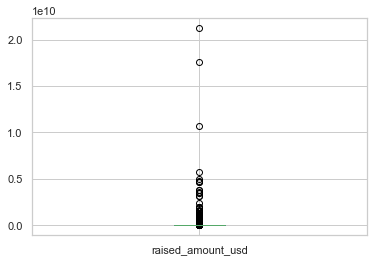

In [26]:
rounds2_raw[raised_amount_usd].plot(kind='box')

- **Values are extremely skewed**

 ## Checkpoint 1: Data Cleaning 1

Cleaning the compamies dataframes

In [27]:
alphanumeric = string.ascii_letters + string.digits


def clean_permalink(permalink: str) -> str:
    """cleans and standardize the permalink
    Args:
        permalink (str): raw permalink

    Returns:
        str: cleaned and lowercase permalink
    """
    valid_chars = alphanumeric+"/-"
    return (''.join([ch for ch in permalink if ch in valid_chars])).lower()
    # return permalink.encode('utf-8').decode('ascii', 'ignore').lower()


def clean_company_name(company_name: str) -> str:
    """cleans and standardize the company name

    Args:
        permalink (str): raw company name

    Returns:
        str: cleaned and lowercase company name
    """
    # Ref: https://companieshouse.blog.gov.uk/2019/02/14/symbols-and-characters-in-a-company-name/
    valid_chars = alphanumeric+".-(),&@£$€¥#♥;: "
    return (''.join([ch for ch in company_name if ch in valid_chars])).lower()


def clean_category_list(category_list: str) -> List[str]:
    """separates, cleans and standardize the category list

    Args:
        permalink (str): raw category list

    Returns:
        str: separated, cleaned and lowercase category list
    """
    # strip and split
    category_list = [c.strip() for c in str(category_list).strip().split("|")]
    # Remove unwanted characters
    category_list = list(map(lambda cn: ''.join(
        [ch for ch in cn.lower() if ch in string.ascii_letters]), category_list))
    return category_list


def clean_companies_data(df: pd.DataFrame) -> pd.DataFrame:
    """Cleans companies dataframe

    Args:
        df (pd.DataFrame): Raw companies dataframe

    Returns:
        pd.DataFrame: Cleaned companies dataframe
    """
    # Fix columns
    # dropping homepage_url as I don't see significance
    df = df[[
        permalink, name_c, category_list, status_c, country_code_c]]

    # Fix rows with missing values
    df = df[df[name_c].notnull()]
    df = df[df[category_list].notnull()]
    df = df[df[country_code_c].notnull()]
    df = df[df[status_c].isin(['operating', 'ipo'])]

    # Standardize and invalid values
    df[permalink_clean] = df[permalink].apply(clean_permalink)
    df[name_c_clean] = df[name_c].apply(clean_company_name)
    # Lets make country list a clean list
    df[category_list_clean] = df[category_list].apply(
        clean_category_list)
    return df



In [28]:
companies = clean_companies_data(companies_raw)
# companies_frame.to_csv("companies_frame.csv", encoding=default_ecoding, quoting=csv.QUOTE_ALL, index=False)

# How many unique companies are present in companies?

In [29]:
unique_companies = companies[permalink_clean].unique()
print(
    f"Companies:Unique companies before cleaning:{len(companies_raw[permalink].unique())}")
print(f"Companies:Unique companies after cleaning:{len(unique_companies)}")


Companies:Unique companies before cleaning:66368
Companies:Unique companies after cleaning:48353


In [30]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48353 entries, 0 to 66366
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   permalink            48353 non-null  object
 1   name                 48353 non-null  object
 2   category_list        48353 non-null  object
 3   status               48353 non-null  object
 4   country_code         48353 non-null  object
 5   permalink_clean      48353 non-null  object
 6   name_clean           48353 non-null  object
 7   category_list_clean  48353 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


Cleaning the rounds2 dataframe

In [31]:


def clean_rounds2_frame(df: pd.DataFrame) -> pd.DataFrame:
    """ Cleans Rounds2 dataframe

    Args:
        df (pd.DataFrame): Raw Rounds2 dataframe

    Returns:
        pd.DataFrame: Cleaned Rounds2 dataframe
    """
    df = df[[company_permalink, funding_round_type, raised_amount_usd]]
    df[company_permalink_clean] = df[company_permalink].apply(clean_permalink)
    # Filtering
    df = df[df[raised_amount_usd].notnull()]
    # pick only compamies which are present in cleaned compamies frame
    df = df[df[company_permalink_clean].isin(unique_companies)]
    return df

In [32]:
rounds2 = clean_rounds2_frame(rounds2_raw)
# rounds2.to_csv("rounds2_frame.csv", encoding=default_ecoding,quoting=csv.QUOTE_ALL, index=False)

<ipython-input-31-10ca24ce291f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[company_permalink_clean] = df[company_permalink].apply(clean_permalink)


In [33]:
def print_information() -> None:
    """Prints answer to few basic questions"""
    print(
        f"Rounds2:Unique companies before cleaning:{len(rounds2_raw[company_permalink].unique())}")
    print(
        f"Rounds2:Unique companies after cleaning:{len(rounds2[company_permalink_clean].unique())}")
    t1 = companies_raw[permalink].str.lower().unique().shape[0]
    t2 = rounds2_raw[company_permalink].str.lower().unique().shape[0]
    print(f"Total companies in original companies file: {t1}")
    print(f"Total companies in original rounds2 file: {t2}")
    print(f"Compamies count comparision before cleaning: {abs(t1-t2)}")
    t1 = companies[permalink_clean].str.lower().unique().shape[0]
    t2 = rounds2[company_permalink_clean].str.lower().unique().shape[0]
    print(f"Total companies in cleaned companies data: {t1}")
    print(f"Total companies in cleaned rounds2 data: {t2}")
    print(f"Compamies count comparision after cleaning: {abs(t1-t2)}")
    print(
        f"companies count diff in companies frame but not in rounds2 frame: {len(set(companies[permalink_clean]) - set(rounds2[company_permalink_clean]))}")
    print(
        f"companies count diff in rounds2 frame but not in companies frame: {len(set(rounds2[company_permalink_clean])-set(companies[permalink_clean]))}")


In [34]:
print_information()

Rounds2:Unique companies before cleaning:90247
Rounds2:Unique companies after cleaning:40470
Total companies in original companies file: 66368
Total companies in original rounds2 file: 66370
Compamies count comparision before cleaning: 2
Total companies in cleaned companies data: 48353
Total companies in cleaned rounds2 data: 40470
Compamies count comparision after cleaning: 7883
companies count diff in companies frame but not in rounds2 frame: 7883
companies count diff in rounds2 frame but not in companies frame: 0


- We can see that all the companies which are present in rounds2 are also present in companies frame
- In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.
  - **permalink**
- How many unique companies are present in rounds2?
  - **Unique companies before cleaning:90247**
  - **Unique companies after cleaning:40470**
- Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N
  - **Y**

In [35]:
def flat_2d_list(lst: Iterable[Iterable]) -> Iterable:
    return functools.reduce(operator.iconcat, lst, [])


def plot_series(series: pd.Series, title: str, xlabel: str, ylabel: str, display_format: str = '{0:,.0f}', x_rotation=0, y_rotation=0) -> None:
    """Bar plots a interger series

    Args:
        series (pd.Series): interger series
    """
    ax = sns.barplot(x=series.index, y=series)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    plt.xticks(rotation=x_rotation)
    plt.yticks(rotation=y_rotation)
    
    # Ref: https://github.com/mwaskom/seaborn/issues/1582
    for i, p in enumerate(ax.patches):
        ax.annotate(display_format.format(series.iloc[i]), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 4), textcoords='offset points')
    plt.show()


def plot_and_print_companies_information():
    company_duplication_count_by_name = companies[name_c_clean].value_counts(
    ).value_counts()
    display(company_duplication_count_by_name)
    plot_series(company_duplication_count_by_name, "Company duplicate count by name",
                "Duplicate Count", "Company Count")
    flattened_categories = pd.Series(flat_2d_list(
        companies[category_list_clean])).value_counts().nlargest(5)
    display(flattened_categories)
    plot_series(flattened_categories, "Top 5 categories", "Category", "Count")
    top10_countries_forcompany_count = companies[country_code_c].value_counts(
    ).nlargest(10)
    display(top10_countries_forcompany_count)
    plot_series(top10_countries_forcompany_count,
                "Top 10 countries with most companies", "Country", "Company Count")



1    48034
2      143
3        7
4        3
Name: name_clean, dtype: int64

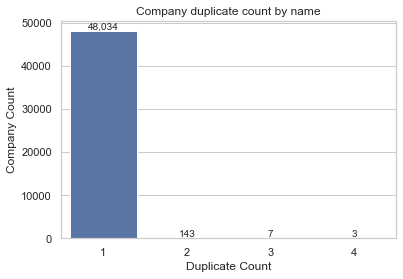

software         6635
mobile           4126
biotechnology    3784
ecommerce        3284
socialmedia      2040
dtype: int64

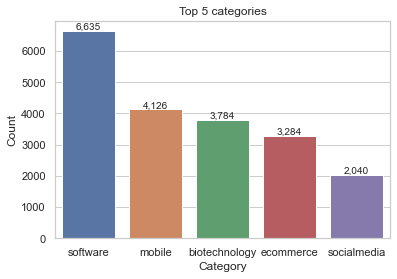

USA    29845
GBR     3109
CAN     1567
IND     1440
CHN     1413
FRA      952
DEU      878
ISR      789
ESP      646
AUS      428
Name: country_code, dtype: int64

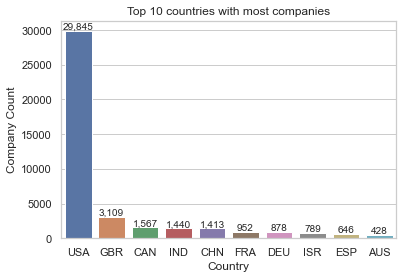

In [36]:
plot_and_print_companies_information()

### In above results and plots we can see that
 - in companies file (for name field)
   - 48034 companies have single entry
   - 143 companies are duplicated once
   - 7 companies are duplicated thrice
   - 3 companies are duplicated four times
     - Note: We can analyse why and which companies are duplicated names
 - software(6635), mobile(4126), biotechnology(3784), ecommerce(3284), socialmedia(2040) are the top fields where companies are working now a days
 - USA(29845), GBR(3109), CAN(1567), IND(1440), CHN(1413), FRA(952), DEU(878), ISR(789), ESP(646), AUS(428) are top 10 contries with highest companies

#### Company name duplication investigation

In [37]:
company_names_with_duplicated_entries = (
    companies[name_c_clean].value_counts() > 1).index
duplicated_companies = companies[companies[name_c_clean].isin(
    company_names_with_duplicated_entries)]
duplicated_companies.to_csv(
    "duplicated_companies.csv", index=False, quoting=csv.QUOTE_ALL)


- **It turns out those are really different companies**

In [38]:
rounds2.columns

Index(['company_permalink', 'funding_round_type', 'raised_amount_usd',
       'company_permalink_clean'],
      dtype='object')

In [39]:
def print_stats(ser_data: pd.Series) -> None:
    # https://www.kaggle.com/maunish/osic-super-cool-eda-and-pytorch-baseline/notebook
    print(f"{y_}Max value: {ser_data.max()} \n{r_}Min value: {ser_data.min()}\n{g_}Mean: {round(ser_data.mean(),2)}\n{b_}Standard Deviation: {round(ser_data.std(),2)}")


def plot_investmet_count_distribution(ser_data: pd.Series, color: str, title: str, xlabel: str, ylabel: str, show_stats=True) -> None:
    plt.figure(dpi=100)
    ax = sns.distplot(ser_data, color=color)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    # https://html.developreference.com/article/13223515/Matplotlib+float+values+on+the+axis+instead+of+integers
    locator = matplotlib.ticker.MultipleLocator(2)
    plt.gca().xaxis.set_major_locator(locator)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)
    if show_stats:
        print_stats(ser_data)
    plt.show()

Max value: 19 
Min value: 1
Mean: 1.8
Standard Deviation: 1.41


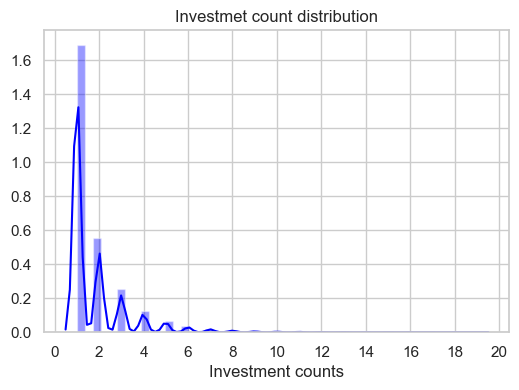

In [40]:
plot_investmet_count_distribution(
    rounds2[company_permalink_clean].value_counts(),
    'blue',
    "Investmet count distribution",
    "Investment counts",
    ""
)

In [41]:
def plot_investmet_distribution(ser_data: pd.Series, color: str, title: str, xlabel: str, ylabel: str, show_stats=True) -> None:
    plt.figure(dpi=100)
    ax = sns.distplot(ser_data, color=color)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    if show_stats:
        print_stats(ser_data)
    plt.show()

Max value: 23.780654435222438 
Min value: 0.0
Mean: 14.11
Standard Deviation: 2.15


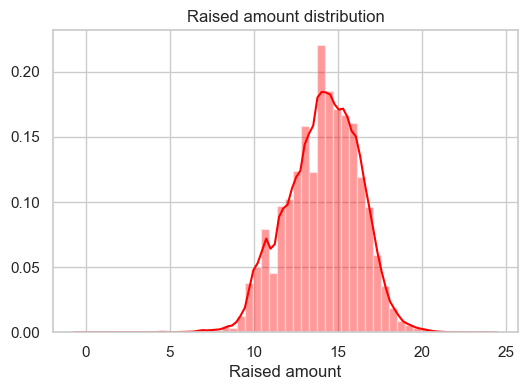

In [42]:
plot_investmet_distribution(
    np.log(rounds2[rounds2[raised_amount_usd] > 0][raised_amount_usd]),
    'red',
    "Raised amount distribution",
    "Raised amount",
    ""
)

- **We can see that data is highly skewed**

Max value: 23.780654435222438 
Min value: 0.0
Mean: 14.11
Standard Deviation: 2.15


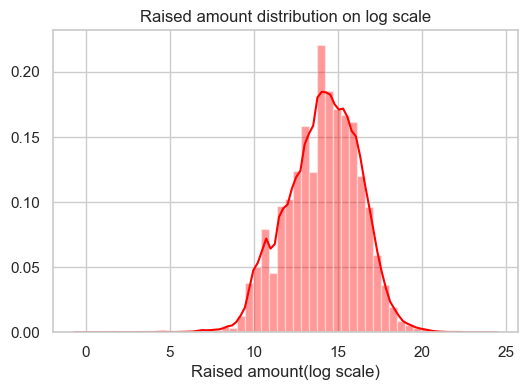

In [43]:
plot_investmet_distribution(
    np.log(rounds2[rounds2[raised_amount_usd] > 0][raised_amount_usd]),
    'red',
    "Raised amount distribution on log scale",
    "Raised amount(log scale)",
    ""
)


- **On log scale it looks like normal distribution, ie original distribution is power distribution**

### Lets do box and boxen plot 

In [44]:
def plot_investmet_boxplot(ser_data: pd.Series, color: str, title: str, xlabel: str, ylabel: str, show_stats=True, is_boxen=False) -> None:
    plt.figure(dpi=100)
    if is_boxen:
        ax = sns.boxenplot(ser_data, color=color)
    else:
        ax = sns.boxplot(ser_data, color=color)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    if show_stats:
        print_stats(ser_data)
    plt.show()

Max value: 21271935000.0 
Min value: 1.0
Mean: 10367569.21
Standard Deviation: 120298248.78


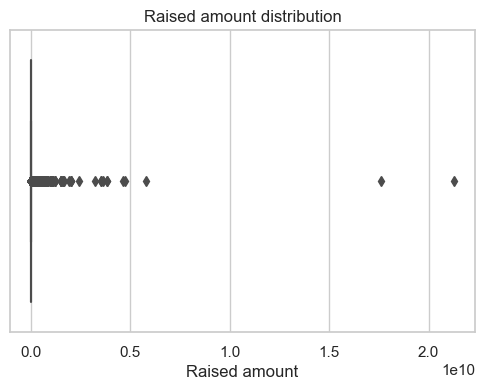

In [45]:
plot_investmet_boxplot(
    rounds2[rounds2[raised_amount_usd] > 0][raised_amount_usd],
    'red',
    "Raised amount distribution",
    "Raised amount",
    ""
)

Max value: 23.780654435222438 
Min value: 0.0
Mean: 14.11
Standard Deviation: 2.15


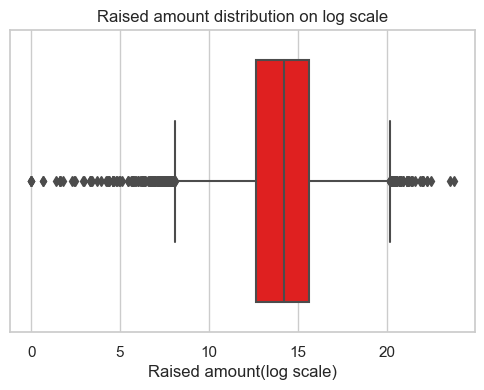

In [46]:
plot_investmet_boxplot(
    np.log(rounds2[rounds2[raised_amount_usd] > 0][raised_amount_usd]),
    'red',
    "Raised amount distribution on log scale",
    "Raised amount(log scale)",
    ""
)

Max value: 21271935000.0 
Min value: 1.0
Mean: 10367569.21
Standard Deviation: 120298248.78


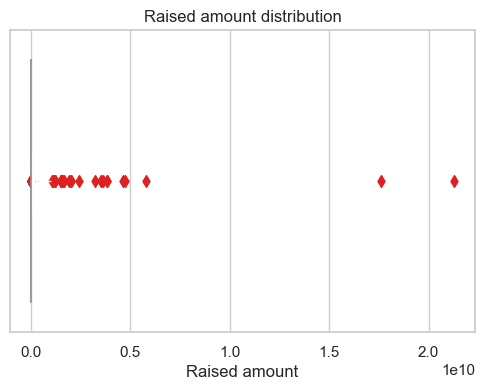

In [47]:
plot_investmet_boxplot(
    rounds2[rounds2[raised_amount_usd] > 0][raised_amount_usd],
    'red',
    "Raised amount distribution",
    "Raised amount",
    "",
    is_boxen=True
)

Max value: 23.780654435222438 
Min value: 0.0
Mean: 14.11
Standard Deviation: 2.15


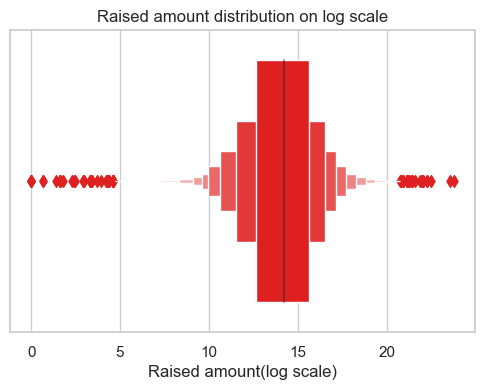

In [48]:
plot_investmet_boxplot(
    np.log(rounds2[rounds2[raised_amount_usd] > 0][raised_amount_usd]),
    'red',
    "Raised amount distribution on log scale",
    "Raised amount(log scale)",
    "",
    is_boxen=True
)

- **We can see that investments count is externally skewed to right**

In [49]:
def print_and_display_funding_types_data() -> None:
    funding_type_value_counts = rounds2[funding_round_type].value_counts()
    display(funding_type_value_counts)
    plt.figure(figsize=(15, 7))
    plot_series(funding_type_value_counts, title="Funding Type Distribution",
                xlabel="Funding Type", ylabel="Investment Count", x_rotation=45)


venture                  37420
seed                     18708
debt_financing            5384
angel                     3691
grant                     1756
private_equity            1524
convertible_note          1216
undisclosed               1183
equity_crowdfunding       1113
post_ipo_equity            517
product_crowdfunding       316
post_ipo_debt              130
non_equity_assistance       56
secondary_market            21
Name: funding_round_type, dtype: int64

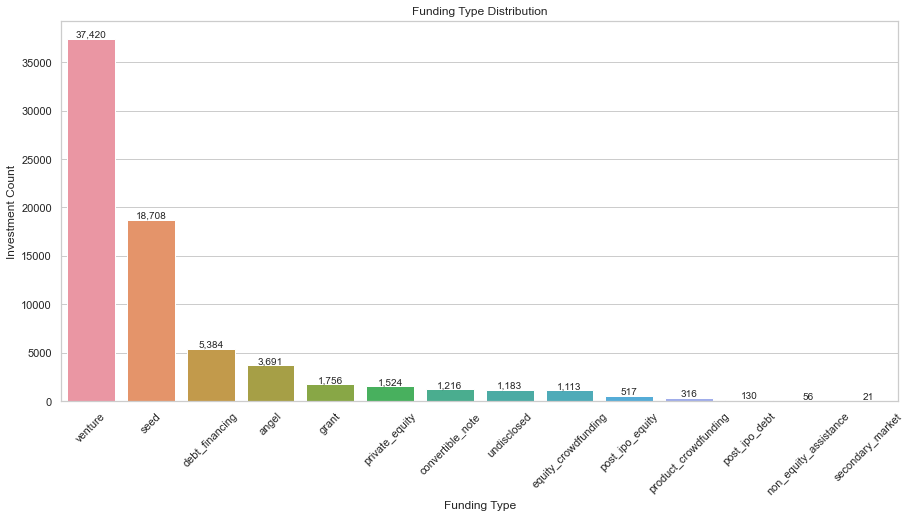

In [50]:
print_and_display_funding_types_data()

#### Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?

In [51]:
master_frame = companies.merge(
    rounds2,
    left_on=permalink_clean,
    right_on=company_permalink_clean,
    how="inner"
)
master_frame.shape[0]


73035

Lets check for nulls now

In [52]:
master_frame.isnull().sum()


permalink                  0
name                       0
category_list              0
status                     0
country_code               0
permalink_clean            0
name_clean                 0
category_list_clean        0
company_permalink          0
funding_round_type         0
raised_amount_usd          0
company_permalink_clean    0
dtype: int64

As we can see that now we have clean data, we can proceed further

In [53]:
# master_frame.to_csv('master_frame.csv', index=False, quoting=csv.QUOTE_ALL)

### Checkpoint 2: Funding Type Analysis
- 1. Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity) and report the answers in Table 2.1
- 2. Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?
**Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round, which investment type is the most suitable for them?**

In [54]:
def get_average_invested_amounts_funding_round_type() -> pd.DataFrame:
    return master_frame[[funding_round_type, raised_amount_usd]].groupby(by=funding_round_type).mean(
    ).reset_index().sort_values(by=raised_amount_usd, ascending=False)


def print_mean_of_and_most_suited_investment_type() -> None:
    average_invested_amounts = get_average_invested_amounts_funding_round_type()
    # Ref : https://pbpython.com/styling-pandas.html
    format_dict = {raised_amount_usd: '${0:,.2f}'}
    display(average_invested_amounts.style.format(format_dict).hide_index())
    display(average_invested_amounts[((5000000 <= average_invested_amounts[raised_amount_usd]) & (average_invested_amounts[raised_amount_usd]
                                                                                                  <= 15000000))].style.format(format_dict).hide_index())

In [55]:
print_mean_of_and_most_suited_investment_type()

funding_round_type,raised_amount_usd
post_ipo_debt,"$176,579,783.90"
secondary_market,"$111,600,186.86"
private_equity,"$75,828,605.36"
post_ipo_equity,"$52,657,221.49"
debt_financing,"$18,312,762.99"
undisclosed,"$15,857,723.68"
venture,"$11,758,410.32"
grant,"$4,347,015.40"
product_crowdfunding,"$1,357,521.55"
convertible_note,"$1,355,254.19"


funding_round_type,raised_amount_usd
venture,"$11,758,410.32"


### The best investments type will be : venture

In [56]:

unfiltered_master_frame = master_frame.copy()


Identify the investment type and, for further analysis, filter the data so it only contains the chosen investment type.

In [57]:
master_frame.shape

(73035, 12)

In [58]:
master_frame = master_frame[master_frame[funding_round_type] == 'venture']


In [59]:
master_frame.shape

(37420, 12)

Ref
 - https://worldpopulationreview.com/country-rankings/english-speaking-countries
 - https://raw.githubusercontent.com/stefangabos/world_countries/master/data/en/countries.csv
 - https://github.com/stefangabos/world_countries

In [60]:


def read_english_speaking_country_data() -> None:
    countries = pd.read_csv("countries.csv")
    countries['name_l'] = countries['name'].str.lower()
    eng_countries = pd.read_csv("EnglishSpeakingCountries.csv")
    eng_countries = eng_countries['country'].str.lower()
    return countries, eng_countries


def map_eng_rank_to_ccode(country_to_match, match_series):
    res = list(filter(lambda t: fuzz.token_set_ratio(
        country_to_match, t) > 90, match_series))
    return True if res else False


def add_english_speaking_flag_master_frame() -> None:
    countries, eng_countries = read_english_speaking_country_data()
    countries['IsEnglish'] = countries['name_l'].apply(
        lambda n: map_eng_rank_to_ccode(n, eng_countries))
    countries['alpha3_u'] = countries['alpha3'].str.upper()
    eng_countries_filtered = list(
        countries[countries['IsEnglish']]['alpha3_u'])
    master_frame['IsEnglish'] = master_frame['country_code'].apply(
        lambda cc: cc in eng_countries_filtered)



In [61]:
add_english_speaking_flag_master_frame()



## Checkpoint 3: Country Analysis

In [62]:


def get_top_n_highest_invested_countries(top_n: int) -> pd.DataFrame:
    return master_frame[master_frame['IsEnglish'] == True].groupby(country_code_c)[raised_amount_usd].sum(
    ).reset_index().sort_values(by=raised_amount_usd, ascending=False)[:top_n]


def print_highest_invested_countries(top_n_data: pd.DataFrame) -> None:
    avg_invested_amt_name = 'Average Invested Amount'
    top_n_data.columns = ['Country Code', avg_invested_amt_name]
    display_style = {avg_invested_amt_name: '${0:,.2f}'}
    display(top_n_data.style.format(display_style).hide_index())



**Spark Funds wants to see the **top nine** countries which have received the highest total funding (across ALL sectors for the chosen investment type)**

In [63]:
top9 = get_top_n_highest_invested_countries(9)
print_highest_invested_countries(top9)

Country Code,Average Invested Amount
USA,"$319,048,095,051.00"
GBR,"$15,131,586,388.00"
IND,"$13,325,776,192.00"
CAN,"$7,077,008,325.00"
ISR,"$5,614,348,319.00"
SGP,"$2,630,224,405.00"
IRL,"$1,358,509,133.00"
AUS,"$1,180,882,474.00"
MYS,"$802,567,240.00"


 Identify the top three English-speaking countries in the data frame top9.

In [64]:
top3 = top9[:3]
print_highest_invested_countries(top3)


Country Code,Average Invested Amount
USA,"$319,048,095,051.00"
GBR,"$15,131,586,388.00"
IND,"$13,325,776,192.00"


 ## Checkpoint 4: Sector Analysis 1

### Extracting the primary sector of each category list from the category_list column

In [65]:
def extract_primary_sector() -> None:
    master_frame[primary_sector] = master_frame[category_list].str.split("|").apply(
        lambda c: (c[0].strip()))


In [66]:
extract_primary_sector()

In [67]:
mapping = read_nonutf8_encoded_file('mapping.csv')
mapping.head(25)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,0,1,0,0,0,0
6,Ad Targeting,0,0,0,0,0,0,0,0,1
7,Advanced Materials,0,0,0,0,0,1,0,0,0
8,Adventure Travel,1,0,0,0,0,0,0,0,0
9,Advertising,0,0,0,0,0,0,0,0,1


**We can see that there are Nulls and spelling mistakes in above data like Alter0tive should be Alternative, and A0lytics should be Analytics**
**It seems someone replace na with 0, so lets run the spelling check on category_list column**

In [68]:
def get_incorrect_words() -> None:
    data = mapping[mapping[category_list].notna()][category_list]
    allwords = set(flat_2d_list(data.str.split()))
    d = enchant.Dict("en_US")
    invalid_words = set([w for w in allwords if not d.check(w)])
    return invalid_words

In [69]:
get_incorrect_words()

{'&',
 '+',
 '0notechnology',
 '0tural',
 '0vigation',
 '3D',
 'A0lytics',
 'APIs',
 'Alter0tive',
 'Assisitive',
 'Audiobooks',
 'B2B',
 'BPO',
 'Bio-Pharm',
 'Biofuels',
 'Bioinformatics',
 'CRM',
 'Can0bis',
 'Chi0',
 'Coworking',
 'Crowdsourcing',
 'Cyber',
 'Cybersecurity',
 'DIY',
 'DOD/Military',
 'Demographies',
 'EBooks',
 'EDA',
 'EdTech',
 'Ediscovery',
 'Educatio0l',
 'Eyewear',
 'Fi0nce',
 'Fi0ncial',
 'FinTech',
 'Fmcg',
 'Freemium',
 'FreetoPlay',
 'Gamification',
 'Geospatial',
 'Gover0nce',
 'Gps',
 'ICT',
 'IaaS',
 'Jour0lism',
 'M2M',
 'Ma0gement',
 'Mens',
 'MicroBlogging',
 'P2P',
 'PaaS',
 'Perso0l',
 'Perso0lization',
 'Pre',
 'Professio0l',
 'Professio0ls',
 'Promotio0l',
 'Q&A',
 'RFID',
 'SEO',
 'SMS',
 'SNS',
 'SaaS',
 'SexTech',
 'Sig0ge',
 'Theatre',
 'Veteri0ry',
 'Wearables',
 'iOS',
 'mHealth'}

**Now its confirmed that other than na->0 we don't have any other spelling mistakes, sor lets replace 0->na**


In [70]:
def replace_na(str_value: str, ch: str = "0") -> str:
    """replaces \"0\" with na, specifically designed for category list, may not work for others need

    Args:
        str_value (str): category list
        ch (str, optional): Replacemet char. Defaults to "0".

    Returns:
        str: clean cotegory name
    """
    if str_value is not None:
        len_str = len(str_value)
        if len_str > 0:
            if str_value == "0":
                return "na"
            all_indices = [i for i, ltr in enumerate(str_value) if ltr == ch]
            if all_indices:
                for i in all_indices:
                    if i == 0 and str_value[1].isalpha():
                        str_value = "na"+str_value[1:]
                    elif i == (len_str - 1) and (str_value[len_str-2].isalpha() or str_value[len_str-2] != "."):
                        str_value = str_value[:len_str] + "na"
                    elif str_value[len_str-2] != ".":
                        str_value = str_value[:i] + "na" + str_value[(i+1):]
    return str_value


In [71]:
def clean_mappings(mapping: pd.DataFrame) -> pd.DataFrame:
    mapping = mapping[mapping[category_list].notna()]
    mapping[category_list] = mapping[category_list].apply(replace_na)
    return mapping

In [72]:
mapping = clean_mappings(mapping)

<ipython-input-71-a5dda9e79502>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapping[category_list] = mapping[category_list].apply(replace_na)


In [73]:
get_incorrect_words()

{'&',
 '+',
 '3D',
 'APIs',
 'Analytics',
 'Assisitive',
 'Audiobooks',
 'B2B',
 'BPO',
 'Bio-Pharm',
 'Biofuels',
 'Bioinformatics',
 'CRM',
 'Coworking',
 'Crowdsourcing',
 'Cyber',
 'Cybersecurity',
 'DIY',
 'DOD/Military',
 'Demographies',
 'EBooks',
 'EDA',
 'EdTech',
 'Ediscovery',
 'Eyewear',
 'FinTech',
 'Fmcg',
 'Fna0nce',
 'Freemium',
 'FreetoPlay',
 'Gamification',
 'Geospatial',
 'Gps',
 'ICT',
 'IaaS',
 'M2M',
 'Mens',
 'MicroBlogging',
 'P2P',
 'PaaS',
 'Pre',
 'Q&A',
 'RFID',
 'SEO',
 'SMS',
 'SNS',
 'SaaS',
 'SexTech',
 'Theatre',
 'Wearables',
 'iOS',
 'mHealth'}

In [74]:
# mapping.to_csv("mapping_frame.csv", index=False, quoting=csv.QUOTE_ALL)

**We don't have incorrect words in category list**

In [75]:
def add_main_sector_to_master_frame(master_frame: pd.DataFrame, mapping: pd.DataFrame) -> pd.DataFrame:
    melted_mapping = mapping.melt(id_vars=category_list)
    melted_mapping = melted_mapping[melted_mapping['value'] == 1]
    melted_mapping.drop('value', axis=1, inplace=True)
    melted_mapping.columns = [category_list, main_sector]

    master_frame = master_frame.merge(
        melted_mapping, left_on=primary_sector, right_on=category_list, how='inner')
    master_frame.drop('category_list_y', axis=1, inplace=True)
    return master_frame

In [76]:
master_frame = add_main_sector_to_master_frame(master_frame, mapping)

 ## Checkpoint 5: Sector Analysis 2

In [77]:
master_frame.head()

,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
0,/Organization/-Fame,#fame,Media,operating,IND,/organization/-fame,#fame,[media],/organization/-fame,venture,10000000.0,/organization/-fame,True,Media,Entertainment
1,/Organization/90Min,90min,Media|News|Publishing|Soccer|Sports,operating,GBR,/organization/90min,90min,"[media, news, publishing, soccer, sports]",/organization/90min,venture,15000000.0,/organization/90min,True,Media,Entertainment
2,/Organization/90Min,90min,Media|News|Publishing|Soccer|Sports,operating,GBR,/organization/90min,90min,"[media, news, publishing, soccer, sports]",/ORGANIZATION/90MIN,venture,5800000.0,/organization/90min,True,Media,Entertainment
3,/Organization/90Min,90min,Media|News|Publishing|Soccer|Sports,operating,GBR,/organization/90min,90min,"[media, news, publishing, soccer, sports]",/organization/90min,venture,18000000.0,/organization/90min,True,Media,Entertainment
4,/Organization/All-Def-Digital,All Def Digital,Media,operating,USA,/organization/all-def-digital,all def digital,[media],/organization/all-def-digital,venture,5000000.0,/organization/all-def-digital,True,Media,Entertainment


 #### TOP 3 COUNTRIES

In [78]:
USA = "USA"
GBR = "GBR"
IND = "IND"

In [79]:
def filter_data_for_c5(country):
    return master_frame[
        (
            # TODO: Could be done by dict based filtering for nice looking code
            (master_frame[country_code_c].notnull()) &
            (master_frame[country_code_c].notna()) &
            (master_frame[country_code_c] == country) &
            (master_frame[funding_round_type].notnull()) &
            (master_frame[funding_round_type].notna()) &
            (master_frame[funding_round_type] == "venture") &
            (master_frame[raised_amount_usd].notnull()) &
            (master_frame[raised_amount_usd].notna()) &
            (master_frame[raised_amount_usd] >= 5000000) &
            (master_frame[raised_amount_usd] <= 15000000)
        )]

In [80]:
D1 = filter_data_for_c5(USA)
D2 = filter_data_for_c5(GBR)
D3 = filter_data_for_c5(IND)

In [81]:
D1.head()

,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
4,/Organization/All-Def-Digital,All Def Digital,Media,operating,USA,/organization/all-def-digital,all def digital,[media],/organization/all-def-digital,venture,5000000.0,/organization/all-def-digital,True,Media,Entertainment
11,/Organization/Chefs-Feed,ChefsFeed,Media|Mobile|Restaurants|Technology,operating,USA,/organization/chefs-feed,chefsfeed,"[media, mobile, restaurants, technology]",/ORGANIZATION/CHEFS-FEED,venture,5000000.0,/organization/chefs-feed,True,Media,Entertainment
24,/Organization/Mediabong,MEDIABONG,Media|Semantic Search|Video,operating,USA,/organization/mediabong,mediabong,"[media, semanticsearch, video]",/organization/mediabong,venture,5000000.0,/organization/mediabong,True,Media,Entertainment
27,/Organization/Newscorporation,News Corp,Media|News|Publishing,ipo,USA,/organization/newscorporation,news corp,"[media, news, publishing]",/organization/newscorporation,venture,12500000.0,/organization/newscorporation,True,Media,Entertainment
38,/Organization/Vadio,Vadio,Media|Mobile|Video,operating,USA,/organization/vadio,vadio,"[media, mobile, video]",/ORGANIZATION/VADIO,venture,7500000.0,/organization/vadio,True,Media,Entertainment


In [82]:
D2.head()


,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
1,/Organization/90Min,90min,Media|News|Publishing|Soccer|Sports,operating,GBR,/organization/90min,90min,"[media, news, publishing, soccer, sports]",/organization/90min,venture,15000000.0,/organization/90min,True,Media,Entertainment
2,/Organization/90Min,90min,Media|News|Publishing|Soccer|Sports,operating,GBR,/organization/90min,90min,"[media, news, publishing, soccer, sports]",/ORGANIZATION/90MIN,venture,5800000.0,/organization/90min,True,Media,Entertainment
87,/Organization/Azimo,Azimo,Curated Web|Finance Technology|Financial Servi...,operating,GBR,/organization/azimo,azimo,"[curatedweb, financetechnology, financialservi...",/organization/azimo,venture,10000000.0,/organization/azimo,True,Curated Web,"News, Search and Messaging"
98,/Organization/Basekit-Platform,BaseKit,Curated Web|Internet|Web Design,operating,GBR,/organization/basekit-platform,basekit,"[curatedweb, internet, webdesign]",/ORGANIZATION/BASEKIT-PLATFORM,venture,7000000.0,/organization/basekit-platform,True,Curated Web,"News, Search and Messaging"
99,/Organization/Basekit-Platform,BaseKit,Curated Web|Internet|Web Design,operating,GBR,/organization/basekit-platform,basekit,"[curatedweb, internet, webdesign]",/organization/basekit-platform,venture,6818631.0,/organization/basekit-platform,True,Curated Web,"News, Search and Messaging"


In [83]:
D3.head()

,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
0,/Organization/-Fame,#fame,Media,operating,IND,/organization/-fame,#fame,[media],/organization/-fame,venture,10000000.0,/organization/-fame,True,Media,Entertainment
89,/Organization/Babajob,Babajob,Curated Web|Information Technology|Services|St...,operating,IND,/organization/babajob,babajob,"[curatedweb, informationtechnology, services, ...",/organization/babajob,venture,10000000.0,/organization/babajob,True,Curated Web,"News, Search and Messaging"
109,/Organization/Bharat-Matrimony,Bharat Matrimony,Curated Web|Match-Making,operating,IND,/organization/bharat-matrimony,bharat matrimony,"[curatedweb, matchmaking]",/ORGANIZATION/BHARAT-MATRIMONY,venture,11750000.0,/organization/bharat-matrimony,True,Curated Web,"News, Search and Messaging"
124,/Organization/Bluestone-Com,Bluestone.com,Curated Web,operating,IND,/organization/bluestone-com,bluestone.com,[curatedweb],/ORGANIZATION/BLUESTONE-COM,venture,5000000.0,/organization/bluestone-com,True,Curated Web,"News, Search and Messaging"
126,/Organization/Bluestone-Com,Bluestone.com,Curated Web,operating,IND,/organization/bluestone-com,bluestone.com,[curatedweb],/ORGANIZATION/BLUESTONE-COM,venture,10000000.0,/organization/bluestone-com,True,Curated Web,"News, Search and Messaging"


 Total number of investments (count)

In [84]:
print(D1.shape[0], D2.shape[0], D3.shape[0])

8391 479 298


 **Total amount of investment (USD)**

In [85]:
print(D1[raised_amount_usd].sum(),
      D2[raised_amount_usd].sum(), D3[raised_amount_usd].sum())


74757700237.0 4135861456.0 2664944832.0


In [86]:
def print_investment_status(curated_data):
    temp_frame = pd.pivot_table(curated_data, values=raised_amount_usd,
                                index=main_sector, aggfunc=['count', 'sum']).reset_index()
    temp_frame.columns = [main_sector,
                          'raised_amount_usd_count', 'raised_amount_usd_sum']
    return temp_frame

In [87]:
D11 = print_investment_status(D1)
D22 = print_investment_status(D2)
D33 = print_investment_status(D3)

In [88]:
format_dict = {'raised_amount_usd_sum': '${0:,.2f}'}

In [89]:
def print_main_sector_in_order() -> None:
    # Ref: https://stackoverflow.com/questions/61363712/how-to-print-a-pandas-io-formats-style-styler-object
    for rd in [(USA, D11), (GBR, D22), (IND, D33)]:
        print(f"Country: {rd[0]}")
        print("\t Sorted by Investment Count")
        display(rd[1].sort_values(by='raised_amount_usd_count',
                                  ascending=False).style.format(format_dict).hide_index())
        # print("\n\t Sorted by Investment Sum")
        # display(rd[1].sort_values(by='raised_amount_usd_sum',
        #                         ascending=False).style.format(format_dict).hide_index())


In [90]:
print_main_sector_in_order()

Country: USA
	 Sorted by Investment Count


main_sector,raised_amount_usd_count,raised_amount_usd_sum
"Social, Finance, Analytics, Advertising",1943,"$17,190,917,113.00"
Others,1837,"$16,327,124,344.00"
Cleantech / Semiconductors,1783,"$16,164,694,047.00"
"News, Search and Messaging",1046,"$9,222,060,082.00"
Health,718,"$6,488,147,629.00"
Manufacturing,565,"$5,047,527,656.00"
Entertainment,373,"$3,224,067,271.00"
Automotive & Sports,126,"$1,093,162,095.00"


Country: GBR
	 Sorted by Investment Count


main_sector,raised_amount_usd_count,raised_amount_usd_sum
Others,112,"$986,257,559.00"
"Social, Finance, Analytics, Advertising",107,"$878,908,102.00"
Cleantech / Semiconductors,100,"$884,638,112.00"
Entertainment,47,"$411,546,359.00"
"News, Search and Messaging",43,"$354,871,725.00"
Manufacturing,38,"$320,755,095.00"
Health,21,"$179,820,205.00"
Automotive & Sports,11,"$119,064,299.00"


Country: IND
	 Sorted by Investment Count


main_sector,raised_amount_usd_count,raised_amount_usd_sum
Others,94,"$855,989,507.00"
"Social, Finance, Analytics, Advertising",55,"$496,549,550.00"
"News, Search and Messaging",47,"$392,405,775.00"
Entertainment,32,"$272,080,000.00"
Cleantech / Semiconductors,20,"$165,380,000.00"
Manufacturing,20,"$194,900,000.00"
Health,18,"$160,740,000.00"
Automotive & Sports,12,"$126,900,000.00"


In [91]:
# Print complete frame
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [92]:
def get_highest_invested_companies() -> List[Tuple[int, str, List[str], pd.DataFrame]]:
    highest_invested_companies = []
    for df, sectors, c in [(D1, ['Social, Finance, Analytics, Advertising', 'Others'], USA),
                           (D2, [
                            'Others', 'Social, Finance, Analytics, Advertising'], GBR),
                           (D3, ['Others', 'Social, Finance, Analytics, Advertising'], IND)]:
        for i, sector in enumerate(sectors):
            sector_df = df[df[main_sector] == sector]
            highest_invested_value = sector_df[raised_amount_usd].max()
            sector_df = sector_df[sector_df[raised_amount_usd]
                                  == highest_invested_value]
            sector_df.drop_duplicates(subset=name_c, keep=False, inplace=True)
            names = list(sector_df[name_c])
            highest_invested_companies.append((i, c, names, sector_df))
            sector_df = None
            names = None
    return highest_invested_companies

In [93]:
highest_invested_companies = get_highest_invested_companies()

In [94]:
for _, c, companies, _ in highest_invested_companies:
    print(f"{c} : {len(companies)}")

USA : 134
USA : 106
GBR : 4
GBR : 4
IND : 14
IND : 4


In [95]:
for _, c, _, df in highest_invested_companies:
    print(c)
    display(df)

USA


,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
6736,/Organization/Alfalight,Alfalight,Analytics,operating,USA,/organization/alfalight,alfalight,[analytics],/ORGANIZATION/ALFALIGHT,venture,15000000.0,/organization/alfalight,True,Analytics,"Social, Finance, Analytics, Advertising"
6750,/Organization/App-Annie,App Annie,Analytics|Big Data Analytics|Mobile,operating,USA,/organization/app-annie,app annie,"[analytics, bigdataanalytics, mobile]",/ORGANIZATION/APP-ANNIE,venture,15000000.0,/organization/app-annie,True,Analytics,"Social, Finance, Analytics, Advertising"
6754,/Organization/Appboy,Appboy,Analytics|Android|Apps|CRM|iOS|Marketing Autom...,operating,USA,/organization/appboy,appboy,"[analytics, android, apps, crm, ios, marketing...",/ORGANIZATION/APPBOY,venture,15000000.0,/organization/appboy,True,Analytics,"Social, Finance, Analytics, Advertising"
6830,/Organization/Bitly,Bitly,Analytics|Brand Marketing|Computers|Curated We...,operating,USA,/organization/bitly,bitly,"[analytics, brandmarketing, computers, curated...",/ORGANIZATION/BITLY,venture,15000000.0,/organization/bitly,True,Analytics,"Social, Finance, Analytics, Advertising"
6846,/Organization/Bottlenose,Bottlenose,Analytics|Big Data|Ediscovery|Real Time|Search...,operating,USA,/organization/bottlenose,bottlenose,"[analytics, bigdata, ediscovery, realtime, sea...",/ORGANIZATION/BOTTLENOSE,venture,15000000.0,/organization/bottlenose,True,Analytics,"Social, Finance, Analytics, Advertising"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36121,/Organization/Nsi-Software-2,NSI Software,Data Security|Market Research|Technology,operating,USA,/organization/nsi-software-2,nsi software,"[datasecurity, marketresearch, technology]",/organization/nsi-software-2,venture,15000000.0,/organization/nsi-software-2,True,Data Security,"Social, Finance, Analytics, Advertising"
36174,/Organization/Centrify,Centrify,Identity Management|SaaS|Security,operating,USA,/organization/centrify,centrify,"[identitymanagement, saas, security]",/ORGANIZATION/CENTRIFY,venture,15000000.0,/organization/centrify,True,Identity Management,"Social, Finance, Analytics, Advertising"
36208,/Organization/Instantly,Instantly,Market Research|Mobile|Surveys,operating,USA,/organization/instantly,instantly,"[marketresearch, mobile, surveys]",/organization/instantly,venture,15000000.0,/organization/instantly,True,Market Research,"Social, Finance, Analytics, Advertising"
36848,/Organization/Retailnext,RetailNext,Data Visualization|Manufacturing|Retail,operating,USA,/organization/retailnext,retailnext,"[datavisualization, manufacturing, retail]",/ORGANIZATION/RETAILNEXT,venture,15000000.0,/organization/retailnext,True,Data Visualization,"Social, Finance, Analytics, Advertising"


USA


,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
7954,/Organization/Education-Com,Education.com,Education|Parenting|Publishing,operating,USA,/organization/education-com,education.com,"[education, parenting, publishing]",/organization/education-com,venture,15000000.0,/organization/education-com,True,Education,Others
8099,/Organization/Schoology,Schoology,Education|Software|Systems,operating,USA,/organization/schoology,schoology,"[education, software, systems]",/ORGANIZATION/SCHOOLOGY,venture,15000000.0,/organization/schoology,True,Education,Others
8925,/Organization/Couchsurfing-International,Couchsurfing,Hospitality|Hotels|Social Media|Social Network...,operating,USA,/organization/couchsurfing-international,couchsurfing,"[hospitality, hotels, socialmedia, socialnetwo...",/organization/couchsurfing-international,venture,15000000.0,/organization/couchsurfing-international,True,Hospitality,Others
8979,/Organization/Kitchensurfing,Kitchensurfing,Hospitality,operating,USA,/organization/kitchensurfing,kitchensurfing,[hospitality],/organization/kitchensurfing,venture,15000000.0,/organization/kitchensurfing,True,Hospitality,Others
10551,/Organization/1Stdibs,1stdibs,E-Commerce,operating,USA,/organization/1stdibs,1stdibs,[ecommerce],/ORGANIZATION/1STDIBS,venture,15000000.0,/organization/1stdibs,True,E-Commerce,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35457,/Organization/Remind101,Remind,All Students|Collaboration|Mobile,operating,USA,/organization/remind101,remind,"[allstudents, collaboration, mobile]",/ORGANIZATION/REMIND101,venture,15000000.0,/organization/remind101,True,All Students,Others
36686,/Organization/Doubledutch,DoubleDutch,Enterprise Application|Enterprise Software|Mar...,operating,USA,/organization/doubledutch,doubledutch,"[enterpriseapplication, enterprisesoftware, ma...",/ORGANIZATION/DOUBLEDUTCH,venture,15000000.0,/organization/doubledutch,True,Enterprise Application,Others
36889,/Organization/Identec-Solutions,Identec Solutions,RFID|Software|Tracking|Wireless,operating,USA,/organization/identec-solutions,identec solutions,"[rfid, software, tracking, wireless]",/organization/identec-solutions,venture,15000000.0,/organization/identec-solutions,True,RFID,Others
37163,/Organization/Predictix,Predictix,Enterprise Resource Planning|Predictive Analyt...,operating,USA,/organization/predictix,predictix,"[enterpriseresourceplanning, predictiveanalyti...",/organization/predictix,venture,15000000.0,/organization/predictix,True,Enterprise Resource Planning,Others


GBR


,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
11384,/Organization/Notonthehighstreet,Notonthehighstreet,E-Commerce,operating,GBR,/organization/notonthehighstreet,notonthehighstreet,[ecommerce],/organization/notonthehighstreet,venture,15000000.0,/organization/notonthehighstreet,True,E-Commerce,Others
16198,/Organization/Environmentiq,EnvironmentIQ,Software,operating,GBR,/organization/environmentiq,environmentiq,[software],/organization/environmentiq,venture,15000000.0,/organization/environmentiq,True,Software,Others
16613,/Organization/Ip-Access,ip.access,Software,operating,GBR,/organization/ip-access,ip.access,[software],/ORGANIZATION/IP-ACCESS,venture,15000000.0,/organization/ip-access,True,Software,Others
33849,/Organization/Silverrail-Technologies,SilverRail Technologies,Technology|Transportation|Travel,operating,GBR,/organization/silverrail-technologies,silverrail technologies,"[technology, transportation, travel]",/organization/silverrail-technologies,venture,15000000.0,/organization/silverrail-technologies,True,Technology,Others


GBR


,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
14884,/Organization/Similarweb,SimilarWeb,Advertising|Analytics|Business Intelligence|Bu...,operating,GBR,/organization/similarweb,similarweb,"[advertising, analytics, businessintelligence,...",/ORGANIZATION/SIMILARWEB,venture,15000000.0,/organization/similarweb,True,Advertising,"Social, Finance, Analytics, Advertising"
19286,/Organization/Zopa,Zopa,Finance|FinTech,operating,GBR,/organization/zopa,zopa,"[finance, fintech]",/ORGANIZATION/ZOPA,venture,15000000.0,/organization/zopa,True,Finance,"Social, Finance, Analytics, Advertising"
28895,/Organization/Opengamma,OpenGamma,Financial Services|FinTech|Open Source|Software,operating,GBR,/organization/opengamma,opengamma,"[financialservices, fintech, opensource, softw...",/ORGANIZATION/OPENGAMMA,venture,15000000.0,/organization/opengamma,True,Financial Services,"Social, Finance, Analytics, Advertising"
30906,/Organization/Mythings,myThings,Accounting|Advertising|Performance Marketing,operating,GBR,/organization/mythings,mythings,"[accounting, advertising, performancemarketing]",/organization/mythings,venture,15000000.0,/organization/mythings,True,Accounting,"Social, Finance, Analytics, Advertising"


IND


,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
9083,/Organization/Zo-Rooms,ZO Rooms,Hospitality|Hotels,operating,IND,/organization/zo-rooms,zo rooms,"[hospitality, hotels]",/ORGANIZATION/ZO-ROOMS,venture,15000000.0,/organization/zo-rooms,True,Hospitality,Others
10749,/Organization/Caratlane,CaratLane,E-Commerce|Jewelry,operating,IND,/organization/caratlane,caratlane,"[ecommerce, jewelry]",/organization/caratlane,venture,15000000.0,/organization/caratlane,True,E-Commerce,Others
10951,/Organization/Firstcry-Com,FirstCry.com,E-Commerce,operating,IND,/organization/firstcry-com,firstcry.com,[ecommerce],/ORGANIZATION/FIRSTCRY-COM,venture,15000000.0,/organization/firstcry-com,True,E-Commerce,Others
11235,/Organization/Limeroad,LimeRoad,E-Commerce|Social Media,operating,IND,/organization/limeroad,limeroad,"[ecommerce, socialmedia]",/ORGANIZATION/LIMEROAD,venture,15000000.0,/organization/limeroad,True,E-Commerce,Others
11494,/Organization/Pepperfry-Com,Pepperfry.com,E-Commerce,operating,IND,/organization/pepperfry-com,pepperfry.com,[ecommerce],/organization/pepperfry-com,venture,15000000.0,/organization/pepperfry-com,True,E-Commerce,Others
11590,/Organization/Roposo,Roposo,E-Commerce|Fashion,operating,IND,/organization/roposo,roposo,"[ecommerce, fashion]",/organization/roposo,venture,15000000.0,/organization/roposo,True,E-Commerce,Others
11878,/Organization/Voylla-Retail-Pvt-Ltd,Voylla Retail Pvt. Ltd.,E-Commerce,operating,IND,/organization/voylla-retail-pvt-ltd,voylla retail pvt. ltd.,[ecommerce],/ORGANIZATION/VOYLLA-RETAIL-PVT-LTD,venture,15000000.0,/organization/voylla-retail-pvt-ltd,True,E-Commerce,Others
20634,/Organization/Classteacher-Learning-Systems,Classteacher Learning Systems,EdTech|Education,operating,IND,/organization/classteacher-learning-systems,classteacher learning systems,"[edtech, education]",/ORGANIZATION/CLASSTEACHER-LEARNING-SYSTEMS,venture,15000000.0,/organization/classteacher-learning-systems,True,EdTech,Others
20700,/Organization/K-12-Techno-Services,K-12 Techno Services,EdTech|Education,operating,IND,/organization/k-12-techno-services,k-12 techno services,"[edtech, education]",/ORGANIZATION/K-12-TECHNO-SERVICES,venture,15000000.0,/organization/k-12-techno-services,True,EdTech,Others
24476,/Organization/Girnarsoft,GirnarSoft,Enterprise Software|Mobile Software Tools|Mobi...,operating,IND,/organization/girnarsoft,girnarsoft,"[enterprisesoftware, mobilesoftwaretools, mobi...",/organization/girnarsoft,venture,15000000.0,/organization/girnarsoft,True,Enterprise Software,Others


IND


,permalink,name,category_list_x,status,country_code,permalink_clean,name_clean,category_list_clean,company_permalink,funding_round_type,raised_amount_usd,company_permalink_clean,IsEnglish,primary_sector,main_sector
14431,/Organization/Komli-Media,Komli Media,Advertising|Analytics|Media,operating,IND,/organization/komli-media,komli media,"[advertising, analytics, media]",/organization/komli-media,venture,15000000.0,/organization/komli-media,True,Advertising,"Social, Finance, Analytics, Advertising"
19163,/Organization/Shiram-Credit,Shiram Credit,Finance,operating,IND,/organization/shiram-credit,shiram credit,[finance],/ORGANIZATION/SHIRAM-CREDIT,venture,15000000.0,/organization/shiram-credit,True,Finance,"Social, Finance, Analytics, Advertising"
30119,/Organization/Apnaloan,ApnaPaisa,Credit|Finance|Marketplaces,operating,IND,/organization/apnaloan,apnapaisa,"[credit, finance, marketplaces]",/ORGANIZATION/APNALOAN,venture,15000000.0,/organization/apnaloan,True,Credit,"Social, Finance, Analytics, Advertising"
32863,/Organization/Shopclues-Com,ShopClues.com,Consumer Internet|E-Commerce|Shopping,operating,IND,/organization/shopclues-com,shopclues.com,"[consumerinternet, ecommerce, shopping]",/ORGANIZATION/SHOPCLUES-COM,venture,15000000.0,/organization/shopclues-com,True,Consumer Internet,"Social, Finance, Analytics, Advertising"


In [96]:
for _, c, companies, _ in highest_invested_companies:
    print(f"{c} : {len(companies)}")

USA : 134
USA : 106
GBR : 4
GBR : 4
IND : 14
IND : 4


In [97]:
for i, c, companies, _ in highest_invested_companies:
    print(
        f"\nCompany(ies) for \"{c}\" {'top sector count-wise' if i==0 else 'second best sector count-wise'}\n")
    print(', '.join(companies))



Company(ies) for "USA" top sector count-wise

Alfalight, App Annie, Appboy, Bitly, Bottlenose, BrightBytes, Cirba, CloudPhysics, DataSift, DataTorrent, Forter, GoodData, Indix, INRIX, Lattice Engines, New Relic, Numerify, Offerpop, OpenGov, OpinionLab, Origami Logic, Planalytics (B2B), Prism Skylabs, Quanterix, RAMP Holdings, RapidMiner, Segment, Splice Machine, Sumo Logic, Valence Health, Xactly Corp, AdRoll, Ampush, Three Stage Media, Compumatrix, Datorama, Definition 6, edo Interactive, Eyeview, Host Analytics, July Systems, Persado, PlaceIQ, Placester, BuyerLink, rewardStyle, Rubicon Project, SAY Media, ShareThis, Sprinklr, Taboola, Tapjoy, Taykey, Tongal, Vibrant Media, VideoAmp, xAd, DApps Fund, Cash4Gold, FastPay, Indiegogo, Kroll Bond Rating Agency, Personal Capital, SigFig, BlueData Software, Inc., Redis Labs, Rocana, True Fit, Zignal Labs, WePay, Univa, Inkling Systems, Kiwi, Inc., textPlus, Yummly, Dig Inn, Talkdesk, Travel Holdings, Yelp, Signal, Lotame, Videology, Aviso, 

In [98]:
def get_top_invested_companies_by_main_sector(country_sector_map: List[Tuple[str, List[str]]], n: int) -> pd.DataFrame:
    def get_country_data(country_code: str, sector: str) -> pd.DataFrame:
        return master_frame[
            ((master_frame[country_code_c] == country_code) &
             (master_frame[funding_round_type] == 'venture') &
                (master_frame[main_sector] == sector)
             )].nlargest(n, raised_amount_usd)

    cols = [name_c, main_sector, raised_amount_usd, country_code_c]
    res_df = pd.DataFrame(columns=cols)
    for country, sectors in country_sector_map:
        for sector in sectors:
            res_df = res_df.append(get_country_data(country, sector)[cols])
    return res_df


In [99]:
get_top_invested_companies_by_main_sector([(USA, ['Social, Finance, Analytics, Advertising', 'Others']),
                                           (GBR, [
                                            'Others', 'Social, Finance, Analytics, Advertising']),
                                           (IND, ['Others', 'Social, Finance, Analytics, Advertising'])], 1)


,name,main_sector,raised_amount_usd,country_code
14260,Groupon,"Social, Finance, Analytics, Advertising",9.500000e+08,USA
8120,SoFi,Others,1.000000e+09,USA
33819,OneWeb,Others,5.000000e+08,GBR
26096,Mereo,"Social, Finance, Analytics, Advertising",1.190000e+08,GBR
10964,Flipkart,Others,1.000000e+09,IND
32862,ShopClues.com,"Social, Finance, Analytics, Advertising",1.000000e+08,IND


### Checkpoint 6: Plots

A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

In [100]:
def get_global_grouped_data() -> pd.DataFrame:
    global_total_fund = unfiltered_master_frame[raised_amount_usd].sum()
    global_grouped_data = unfiltered_master_frame[[funding_round_type, raised_amount_usd]].groupby(funding_round_type).agg(
        {raised_amount_usd: ['sum', 'mean']}
    ).reset_index()

    global_grouped_data.columns = [funding_round_type,
                                   'raised_amount_usd_sum', 'raised_amount_usd_mean']
    global_grouped_data['raised_amount_ratio'] = global_grouped_data['raised_amount_usd_sum']/global_total_fund
    global_grouped_data.sort_values(
        'raised_amount_ratio', ascending=False, inplace=True)
    return global_grouped_data



In [101]:
global_grouped_data = get_global_grouped_data()

In [102]:

k = global_grouped_data.style.format({'raised_amount_usd_mean': '${0:,.2f}',
                                      'raised_amount_usd_sum': '${0:,.2f}',
                                      'raised_amount_ratio': '{0:.2f}'
                                      }).hide_index()
display(k)

funding_round_type,raised_amount_usd_sum,raised_amount_usd_mean,raised_amount_ratio
venture,"$439,999,714,032.00","$11,758,410.32",0.58
private_equity,"$115,562,794,564.00","$75,828,605.36",0.15
debt_financing,"$98,595,915,927.00","$18,312,762.99",0.13
post_ipo_equity,"$27,223,783,508.00","$52,657,221.49",0.04
post_ipo_debt,"$22,955,371,907.00","$176,579,783.90",0.03
undisclosed,"$18,759,687,119.00","$15,857,723.68",0.02
seed,"$14,097,602,330.00","$753,560.10",0.02
grant,"$7,633,359,049.00","$4,347,015.40",0.01
angel,"$3,658,443,230.00","$991,179.42",0.00
secondary_market,"$2,343,603,924.00","$111,600,186.86",0.00


In [103]:
def plot_average_fund_type_share() -> None:
    graph_data = global_grouped_data[global_grouped_data[funding_round_type].isin(
        ['angel', 'venture', 'private_equity'])]

    g = sns.barplot(x="funding_round_type",
                    y='raised_amount_ratio', data=graph_data)
    g.set(xlabel='Funding Round Type',
          ylabel='Investment Proportion', title='Fund Type Share with Average Global Investment')
    # Ref: https://github.com/mwaskom/seaborn/issues/1582
    for i, p in enumerate(g.patches):
        g.annotate('${0:,.2f}'.format(graph_data.iloc[i]['raised_amount_usd_mean']), (p.get_x(
        ) + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 4), textcoords='offset points')
    plt.show()

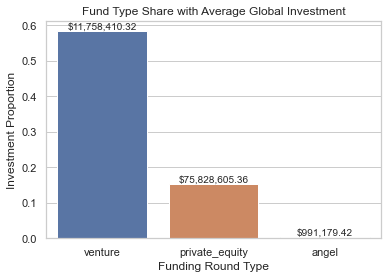

In [104]:
plot_average_fund_type_share()

A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

In [105]:
avg_invested_amt = "Average Invested Amount"
country_code_col_name = "Country Code"
graph_data = top9.sort_values(by=avg_invested_amt, ascending=False)

In [106]:


def plot_top_9_inested_countries(graph_data: pd.DataFrame) -> None:
    plt.figure(figsize=(15, 7))
    g = sns.barplot(x=country_code_col_name,
                    y=avg_invested_amt, data=graph_data)
    g.set(xlabel='Country',
          ylabel='Total Investment', title='Top 9 Countries with highest investments')
    for i, p in enumerate(g.patches):
        g.annotate('${0:,.2f}'.format(graph_data.iloc[i][avg_invested_amt]), (p.get_x(
        ) + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 4), textcoords='offset points')
    plt.show()



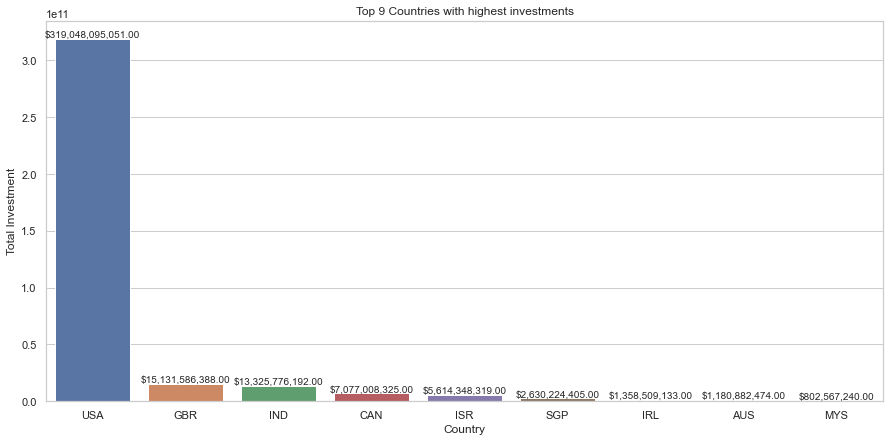

In [107]:
plot_top_9_inested_countries(graph_data)

In [108]:
def plot_top_9_inested_countries_on_log_scale() -> None:

    graph_data['raised_amount_usd_log'] = np.log(graph_data[avg_invested_amt])
    g = sns.barplot(x=country_code_col_name,
                    y="raised_amount_usd_log", data=graph_data)
    g.set(xlabel='Country',
          ylabel='Total Investment (Log Scale)', title='Top 9 Countries with highest investments')
    plt.show()

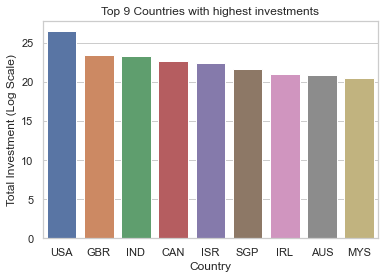

In [109]:
plot_top_9_inested_countries_on_log_scale()

**A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT).**

In [110]:


def plot_sector_wise_investment_comparision() -> None:
    usa_data = D1[main_sector].value_counts()[:3]
    gbr_data = D2[main_sector].value_counts()[:3]
    ind_data = D3[main_sector].value_counts()[:3]

    graph_data = pd.DataFrame(
        {"Sector": usa_data.index, "Count": usa_data.values,
            "Country": [USA for _ in range(len(usa_data))]}
    ).append(pd.DataFrame({"Sector": gbr_data.index, "Count": gbr_data.values, "Country": [GBR for _ in range(len(gbr_data))]})) \
        .append(pd.DataFrame({"Sector": ind_data.index, "Count": ind_data.values, "Country": [IND for _ in range(len(ind_data))]}))

    plt.figure(figsize=(15, 12))
    g = sns.catplot(y="Count", x="Country", hue="Sector",
                    data=graph_data, kind="bar", palette="muted", orient='v', legend_out=True)
    # for i, p in enumerate(g.patches):
    #     g.annotate('${0:,.2f}'.format(graph_data.iloc[i]['Count']), (p.get_x(
    #     ) + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 4), textcoords='offset points')

    g.set(xlabel='Country',
          ylabel='Investment Count', title='Country wise Investment count')
    plt.show()



<Figure size 1080x864 with 0 Axes>

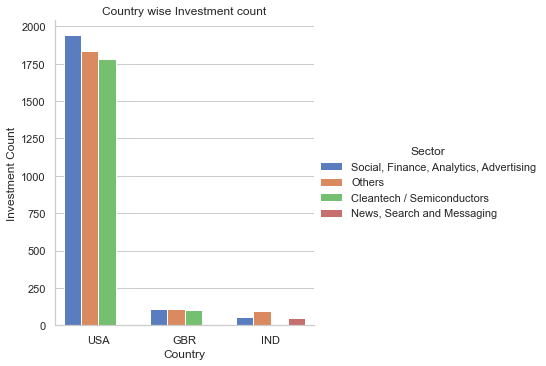

In [111]:
plot_sector_wise_investment_comparision()